In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import imagenet_utils
import imutils
from google.colab.patches import cv2_imshow

In [ ]:
class GradCAM:
  def __init__(self, model, classIdx, inner_model=None, layerName=None):
      self.model = model
      self.classIdx = classIdx
      self.inner_model = inner_model
      if self.inner_model == None:
        self.inner_model = model
      self.layerName = layerName

  def compute_heatmap(self, image, eps=1e-8):
      # construct our gradient model by supplying (1) the inputs
      # to our pre-trained model, (2) the output of the (presumably)
      # final 4D layer in the network, and (3) the output of the
      # softmax activations from the mode
      gradModel = tf.keras.models.Model(inputs=[self.inner_model.inputs],
                    outputs=[self.inner_model.get_layer(self.layerName).output,
                    self.inner_model.output])
      # record operations for automatic differentiation
      with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]
      # use automatic differentiation to compute the gradients
      grads = tape.gradient(loss, convOutputs)
      # compute the guided gradients
      castConvOutputs = tf.cast(convOutputs > 0, "float32")
      castGrads = tf.cast(grads > 0, "float32")
      guidedGrads = castConvOutputs * castGrads * grads
      # the convolution and guided gradients have a batch dimension
      # (which we don't need) so let's grab the volume itself and
      # discard the batch
      convOutputs = convOutputs[0]
      guidedGrads = guidedGrads[0]
      # compute the average of the gradient values, and using them
      # as weights, compute the ponderation of the filters with
      # respect to the weights
      weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
      cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
      # grab the spatial dimensions of the input image and resize
      # the output class activation map to match the input image
      # dimensions
      (w, h) = (image.shape[2], image.shape[1])
      heatmap = cv2.resize(cam.numpy(), (w, h))
      # normalize the heatmap such that all values lie in the range
      # [0, 1], scale the resulting values to the range [0, 255],
      # and then convert to an unsigned 8-bit integer
      numer = heatmap - np.min(heatmap)
      denom = (heatmap.max() - heatmap.min()) + eps
      heatmap = numer / denom
      heatmap = (heatmap * 255).astype("uint8")
      # return the resulting heatmap to the calling function
      return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
      colormap=cv2.COLORMAP_JET):
      # apply the supplied color map to the heatmap and then
      # overlay the heatmap on the input image
      heatmap = cv2.applyColorMap(heatmap, colormap)
      output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
      # return a 2-tuple of the color mapped heatmap and the output,
      # overlaid image
      return (heatmap, output)

In [ ]:
path = '/content/drive/MyDrive/sve_LP-bez augumentacije/test/M/135910052_M_61_LP_jpg.rf.a9353d08e49abaddec68d5b541b2a6c7.jpg'

In [ ]:
clf_model = load_model('LP_fine_tune_87.h5')

In [ ]:
orig = cv2.imread(path)
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = load_img(path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

In [ ]:
resized = cv2.resize(orig, (224, 224))
resized  = cv2.cvtColor(resized , cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (224, 224))
resized = resized.astype('float32') / 255.0
resized = np.expand_dims(resized , axis=0)

# Make a prediction using the model
pred_for_specific_image = clf_model.predict(resized)
class_for_specific_image = np.where(pred_for_specific_image  < 0.5, 'F', 'M')
# Extract the folder name from the file path
folder = os.path.dirname(path)
# Extract the gender from the folder name
gender = folder.split('/')[-1]
# Save the true class based on the extracted gender
if gender == 'F':
    true_class = 'F'
elif gender == 'M':
    true_class = 'M'
else:
    print('Invalid folder name')

label = "Probability for 'M': {:.2f}%, Predicted: {}, True: {}".format(pred_for_specific_image[0][0] * 100,class_for_specific_image[0][0], true_class)
label

1/1 [==============================] - 1s 1s/step


"Probability for 'M': 66.20%, Predicted: M, True: M"

In [ ]:
cam = GradCAM(clf_model, None, inner_model=clf_model.get_layer("resnet50v2"), layerName="conv5_block3_3_conv")

In [ ]:
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

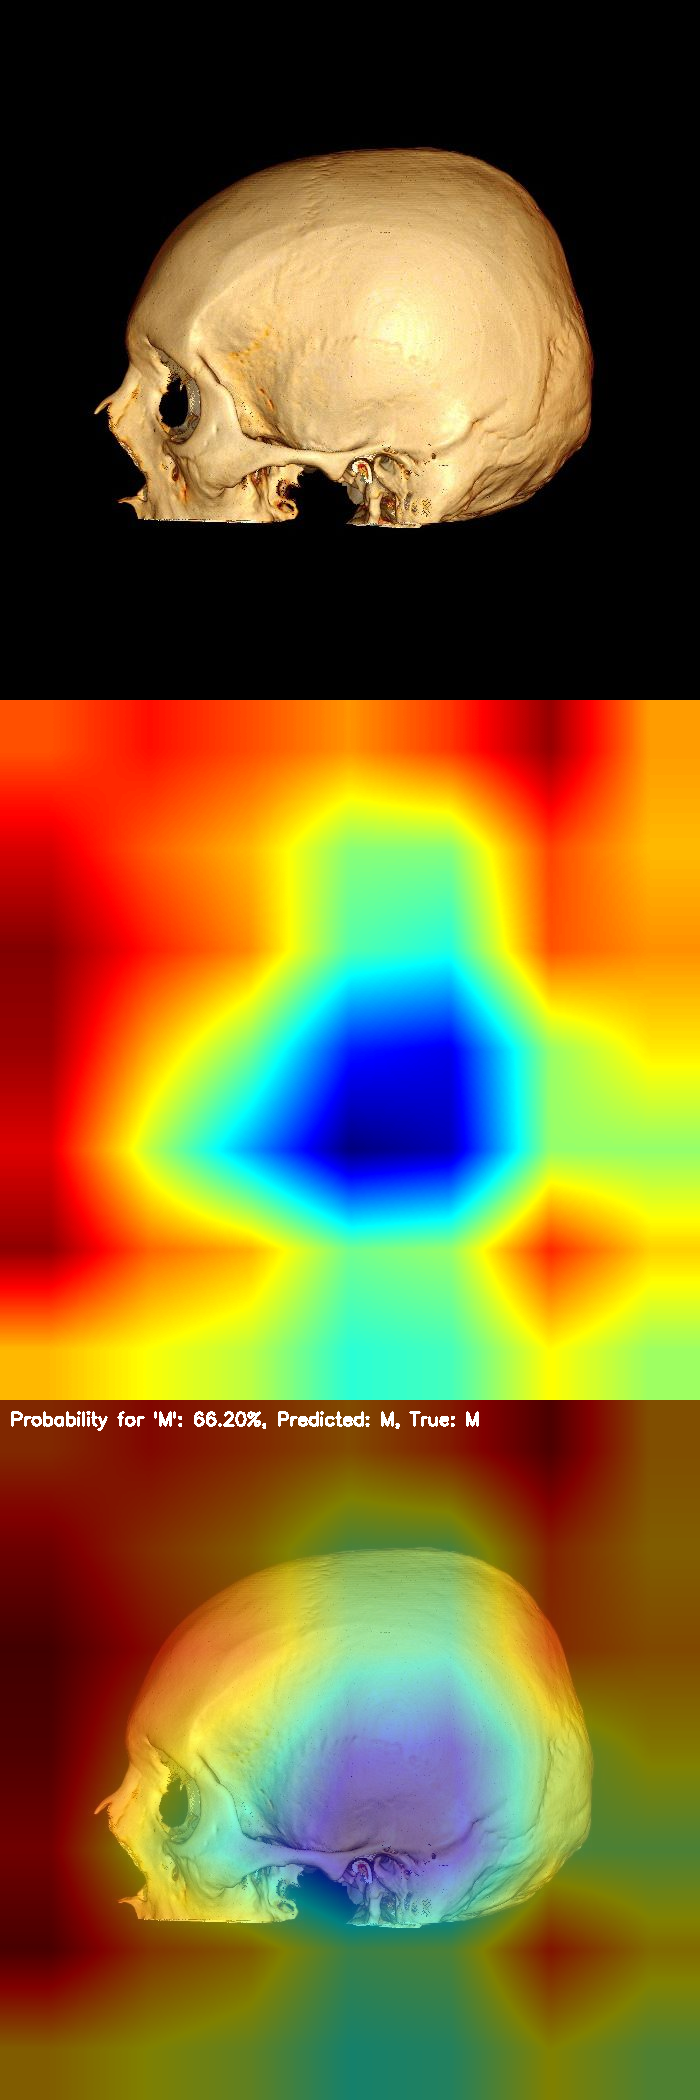

In [ ]:
# draw the predicted label on the output image
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.6, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
ooutput = imutils.resize(output)
cv2_imshow(output)

In [ ]:
activation_layers = [layer.name for layer in reversed(pre_trained_model.layers) if len(layer.output_shape) == 4 and 'relu' in layer.name]

In [ ]:
conv2D_layers = [layer.name for layer in reversed(pre_trained_model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]

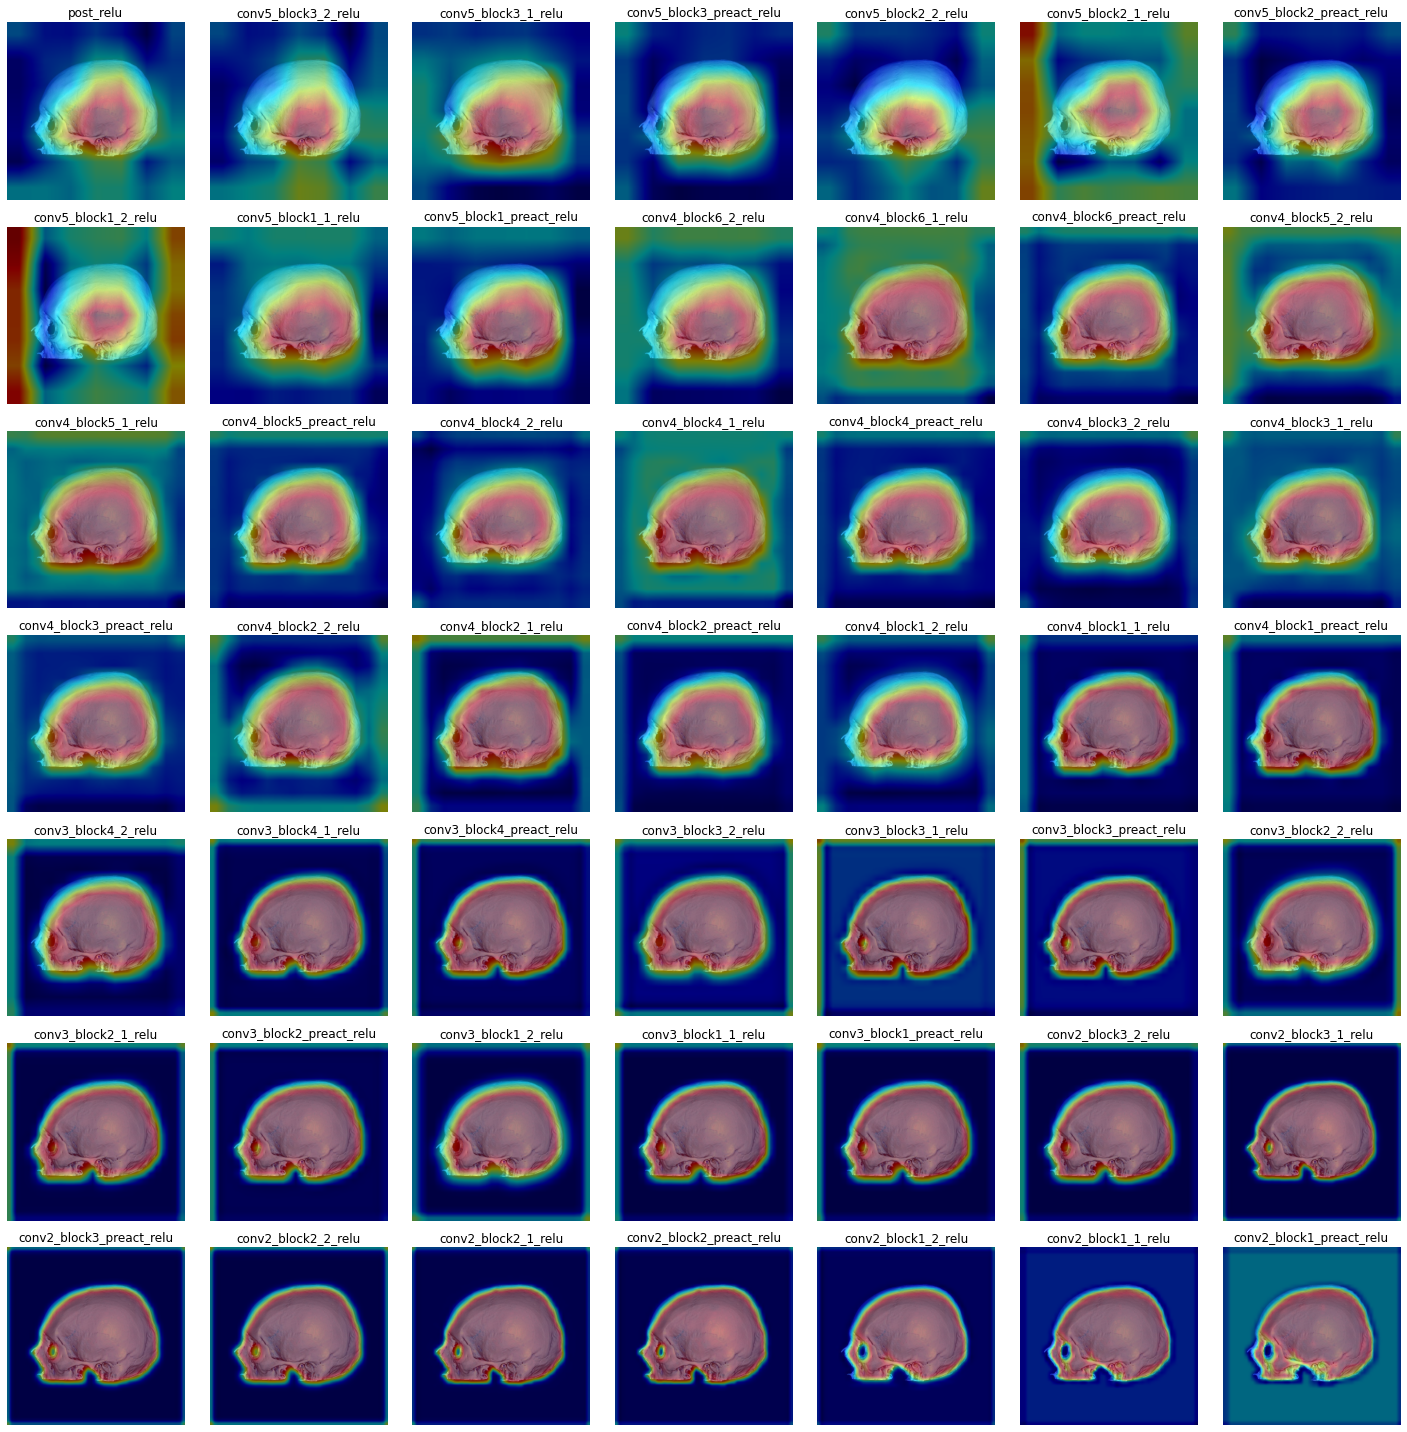

In [ ]:
plt.figure(figsize=(20, 20))
for i, layer in enumerate(activation_layers):
  cam = GradCAM(clf_model, None, inner_model=clf_model.get_layer("resnet50v2"), layerName=layer)
  heatmap = cam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
  (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
  ax = plt.subplot(7, 7, i +1)
  plt.imshow(output)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

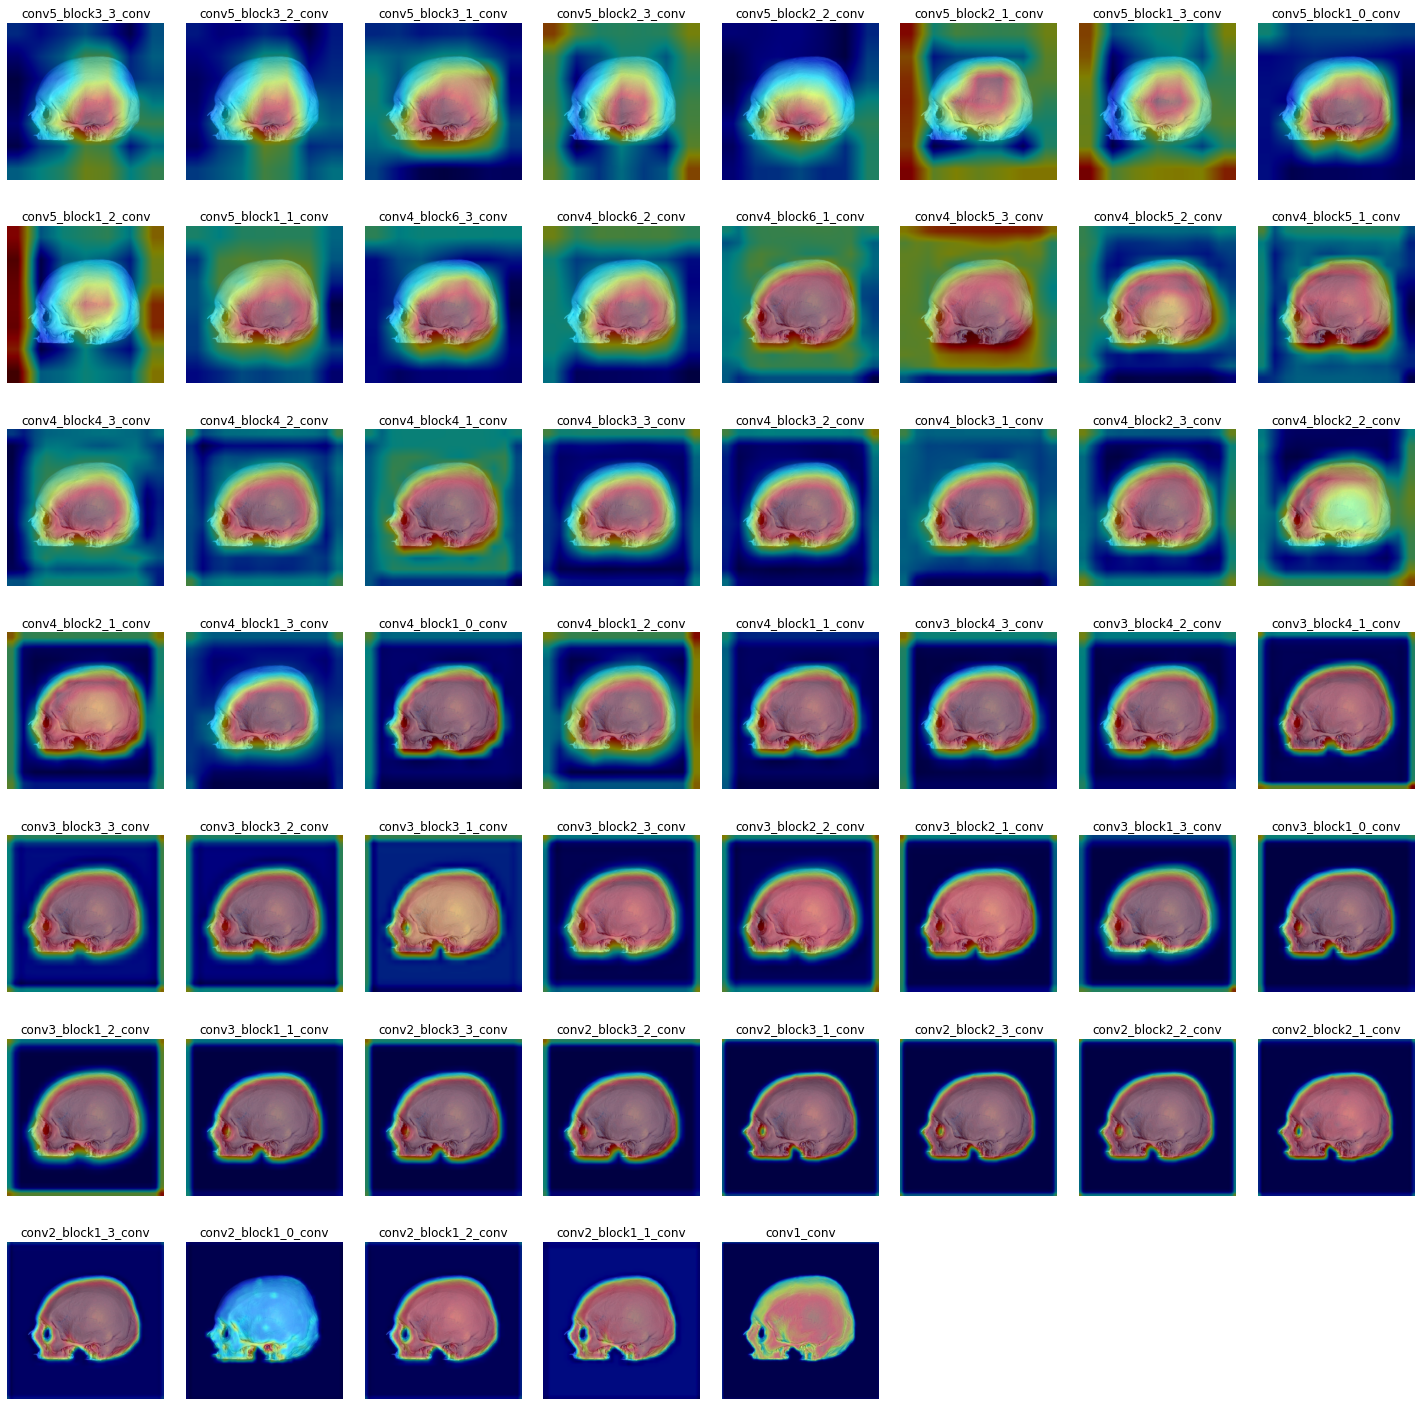

In [ ]:
plt.figure(figsize=(20, 20))
for i, layer in enumerate(conv2D_layers):
  cam = GradCAM(clf_model, None, inner_model=clf_model.get_layer("resnet50v2"), layerName=layer)
  heatmap = cam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
  (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
  ax = plt.subplot(7,8 , i +1)
  plt.imshow(output)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()